## GaussianExample with alternate (original) step2 method

In the original version of the GaussianExample, step2 is implemented in a simpler way than in the papers.  Instead of updating the weights in each iteration of step2, it always uses weight=1 for the gen-level sample in the compaison.

In the original OmniFold paper, they propose instead updating the weights of the previous iteration, rather than always starting from the beginning (weight=1).  I'll try to implement the original version here.


In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-26 16:05:28.951600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:28.951850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:28.968346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:28.968585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:28.968757: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

#max_epochs = 200
#batch_size_setval = 10000
#learning_rate_setval = 1e-3
#patience_setval = 10

#back = 0.1 #fraction of a background process that we would like to subtract
#background_param = (0, 1.2)  # background
#N = 10**5






##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

max_epochs = 200
batch_size_setval = 1000
learning_rate_setval = 1e-4
patience_setval = 40

back = 0.2 #fraction of a background process that we would like to subtract
background_param = (0, 3)  # background
N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 
##   About 3 hours.

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6





In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 1.46 s, sys: 18.1 ms, total: 1.48 s
Wall time: 1.48 s


In [9]:
theta0_G

array([  0.53601021,   1.59599988,  -0.38946309, ..., -10.        ,
        -0.56761009, -10.        ])

In [10]:
theta0_S

array([ 1.37364651,  1.46405948, -0.64976437, ..., -0.29511073,
        0.46869671, -0.28023136])

In [11]:
theta0

array([[  0.53601021,   1.37364651],
       [  1.59599988,   1.46405948],
       [ -0.38946309,  -0.64976437],
       ...,
       [-10.        ,  -0.29511073],
       [ -0.56761009,   0.46869671],
       [-10.        ,  -0.28023136]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(300000,)

In [14]:
theta0.shape

(300000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(300000,)

/tmp/ipykernel_2790119/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


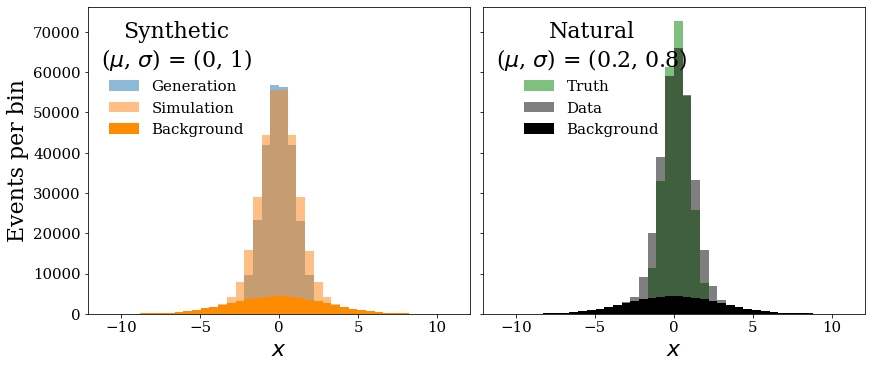

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)


nn_output = np.zeros( shape=(iterations, 2, len(theta0)))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-26 16:05:31.239294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:31.239504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:31.239677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:31.239837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 16:05:31.239996: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([ 1.37364651,  1.46405948, -0.64976437, ..., -0.3350858 ,
       -0.05689625, -0.37910859])

In [21]:
xvals_1.shape

(600000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(600000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 26.8 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])


training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/100


2023-01-26 16:06:51.739574: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-26 16:06:51.742280: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f9b0c019750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 16:06:51.742314: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 16:06:51.742321: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 16:06:51.748474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 16:06:51.853959: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

541/541 [==============================] - 30s 52ms/step - loss: 0.5631 - accuracy: 0.4608 - val_loss: 0.5602 - val_accuracy: 0.4620
Epoch 2/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5604 - accuracy: 0.4589 - val_loss: 0.5582 - val_accuracy: 0.4580
Epoch 3/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5589 - accuracy: 0.4585 - val_loss: 0.5569 - val_accuracy: 0.4580
Epoch 4/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5580 - accuracy: 0.4585 - val_loss: 0.5559 - val_accuracy: 0.4580
Epoch 5/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5573 - accuracy: 0.4585 - val_loss: 0.5552 - val_accuracy: 0.4580
Epoch 6/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5568 - accuracy: 0.4585 - val_loss: 0.5547 - val_accuracy: 0.4580
Epoch 7/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5565 - accuracy: 0.4585 - val_loss: 0.5542 - val_accuracy: 0.4580
Epoch 8/1

541/541 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.4585 - val_loss: 0.5494 - val_accuracy: 0.4580
Epoch 59/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.4585 - val_loss: 0.5494 - val_accuracy: 0.4580
Epoch 60/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5545 - accuracy: 0.4585 - val_loss: 0.5493 - val_accuracy: 0.4580
Epoch 61/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.4585 - val_loss: 0.5492 - val_accuracy: 0.4580
Epoch 62/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5544 - accuracy: 0.4585 - val_loss: 0.5493 - val_accuracy: 0.4580
Epoch 63/100
541/541 [==============================] - 1s 3ms/step - loss: 0.5544 - accuracy: 0.4585 - val_loss: 0.5490 - val_accuracy: 0.4580
Epoch 64/100
541/541 [==============================] - 2s 3ms/step - loss: 0.5543 - accuracy: 0.4585 - val_loss: 0.5492 - val_accuracy: 0.4580
Epoch

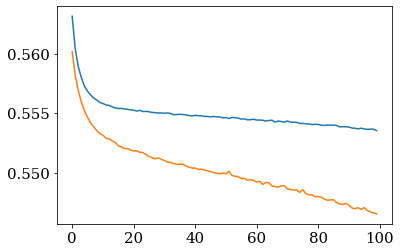

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

34/34 [==============================] - 0s 634us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_2790119/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


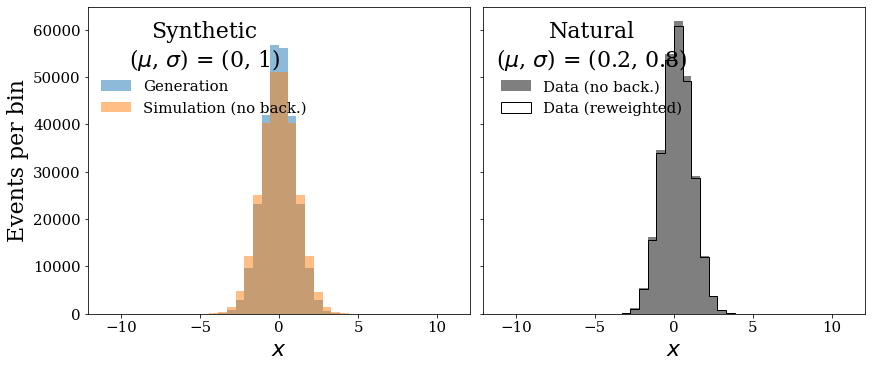

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

34/34 [==============================] - 0s 684us/step


In [32]:
model_output_bgsub

array([[4.7565588e-01],
       [4.7622001e-01],
       [4.8151407e-01],
       ...,
       [8.5061453e-03],
       [1.3828030e-10],
       [1.3186481e-04]], dtype=float32)

In [33]:
model_output_bgsub.shape

(330221, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([4.7565588e-01, 4.7622001e-01, 4.8151407e-01, ..., 8.5061453e-03,
       1.3828030e-10, 1.3186481e-04], dtype=float32)

In [36]:
squeezed_model_output.shape

(330221,)

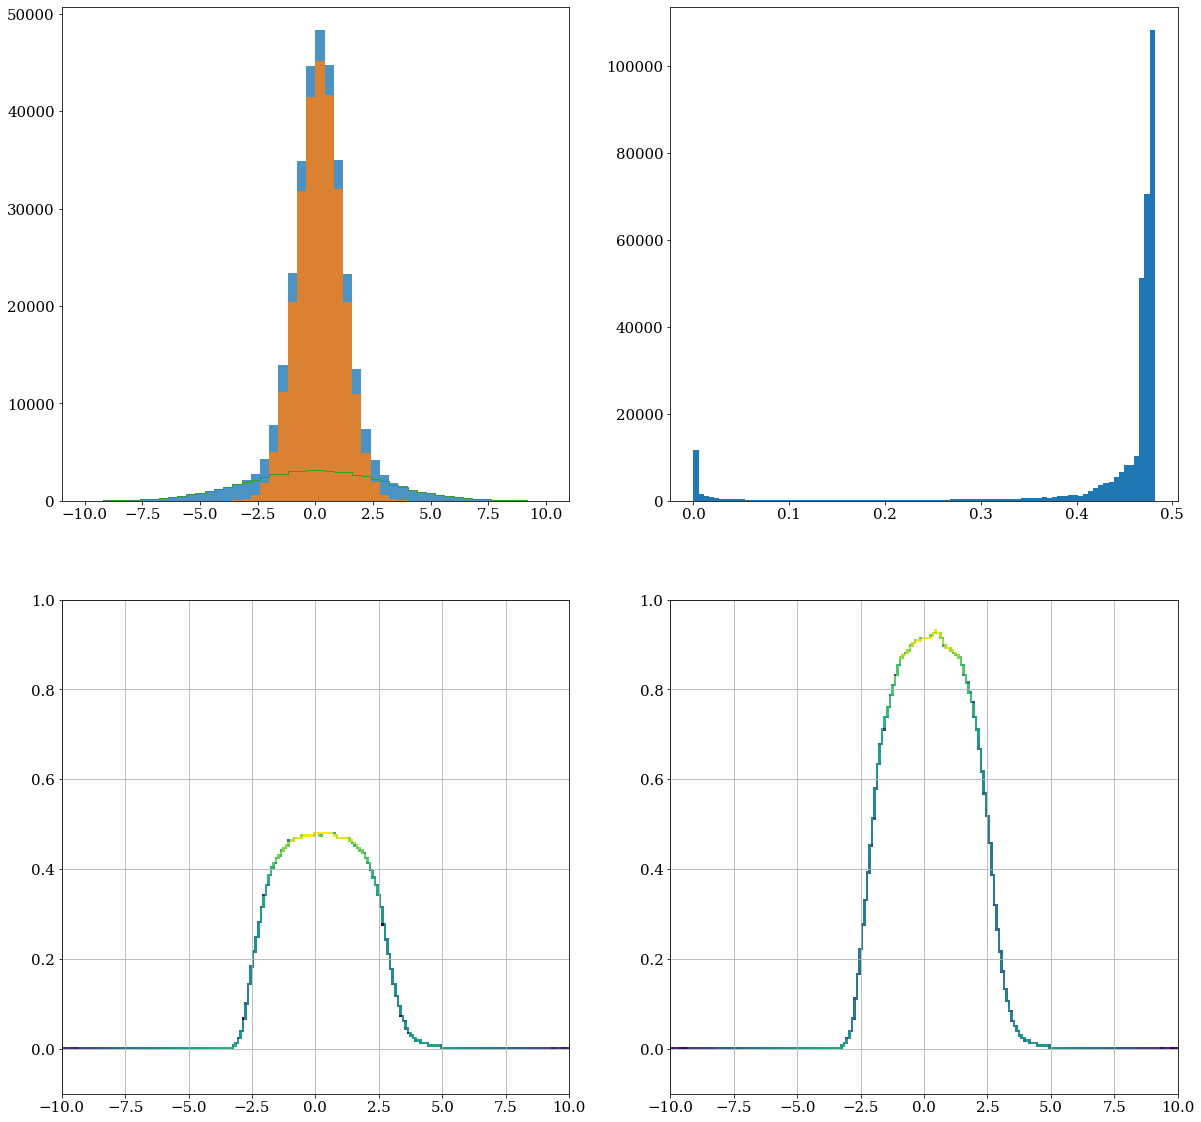

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

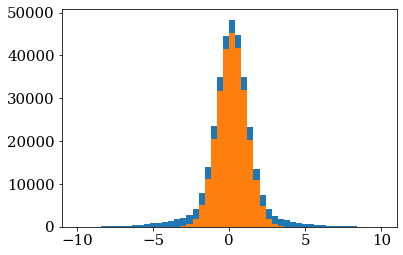

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([1.9000e+01, 1.9000e+01, 3.7000e+01, 4.5000e+01, 7.8000e+01,
        1.0900e+02, 1.4300e+02, 2.1900e+02, 2.5700e+02, 3.8300e+02,
        4.6500e+02, 6.8100e+02, 7.8500e+02, 9.6500e+02, 1.1780e+03,
        1.4640e+03, 1.7170e+03, 2.1000e+03, 2.7610e+03, 4.2610e+03,
        7.7740e+03, 1.3902e+04, 2.3439e+04, 3.4890e+04, 4.4628e+04,
        4.8339e+04, 4.4784e+04, 3.5013e+04, 2.3315e+04, 1.3579e+04,
        7.4090e+03, 4.1880e+03, 2.6300e+03, 1.8210e+03, 1.4950e+03,
        1.1350e+03, 9.4500e+02, 7.4800e+02, 6.3900e+02, 4.8400e+02,
        3.9500e+02, 2.6800e+02, 2.1700e+02, 1.6000e+02, 8.7000e+01,
        8.5000e+01, 4.7000e+01, 3.6000e+01, 2.0000e+01, 1.3000e+01]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6

In [40]:
hist_data_all[0]

array([1.9000e+01, 1.9000e+01, 3.7000e+01, 4.5000e+01, 7.8000e+01,
       1.0900e+02, 1.4300e+02, 2.1900e+02, 2.5700e+02, 3.8300e+02,
       4.6500e+02, 6.8100e+02, 7.8500e+02, 9.6500e+02, 1.1780e+03,
       1.4640e+03, 1.7170e+03, 2.1000e+03, 2.7610e+03, 4.2610e+03,
       7.7740e+03, 1.3902e+04, 2.3439e+04, 3.4890e+04, 4.4628e+04,
       4.8339e+04, 4.4784e+04, 3.5013e+04, 2.3315e+04, 1.3579e+04,
       7.4090e+03, 4.1880e+03, 2.6300e+03, 1.8210e+03, 1.4950e+03,
       1.1350e+03, 9.4500e+02, 7.4800e+02, 6.3900e+02, 4.8400e+02,
       3.9500e+02, 2.6800e+02, 2.1700e+02, 1.6000e+02, 8.7000e+01,
       8.5000e+01, 4.7000e+01, 3.6000e+01, 2.0000e+01, 1.3000e+01])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

In [45]:
signal_frac

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00169779,
       0.00409836, 0.02213162, 0.06619048, 0.21224194, 0.4214973 ,
       0.64921533, 0.8005323 , 0.87060028, 0.9118372 , 0.92887873,
       0.93396636, 0.93120311, 0.91423186, 0.87402959, 0.803962  ,
       0.66162775, 0.46012416, 0.23041825, 0.08951126, 0.02809365,
       0.00704846, 0.0010582 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

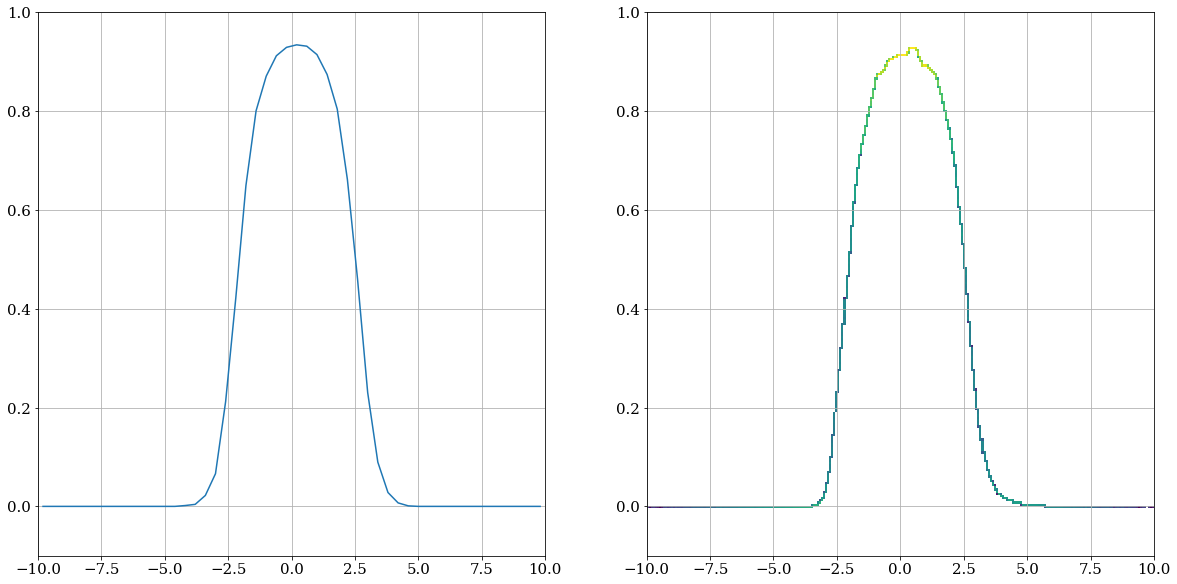

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

#-- owen: adding this
weights_push_last_iteration = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time

for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    
    
    
    weights_push_last_iteration = weights_push
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 

    ##-- owen: save NN output for each iteration, step.
    nn_output[i,0,:] = np.squeeze(  model.predict(theta0_S, batch_size=10000) )


    
    
    
    


    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)


        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,0,:] I think.  See Python-syntax-testing notebook.
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    ##-----------------------------------------------------------------------
    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.
    
    ##-- owen: this is the way it's done in the papers (I think).
    #          At this point weights_push should still have the values from the end of the last iteration.
    weights_2 = np.concatenate((weights_push, weights_pull))
    
    
    

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    #weights_push = reweight(theta0_G)    
    
    
    #-- owen: this is the way it's done in the papers (I think)
    weights_push = weights_push * reweight(theta0_G)    
    
    
    
    
    
    ##-- owen: save NN output for each iteration, step.
    nn_output[i,1,:] = np.squeeze(  model.predict(theta0_G, batch_size=10000) )
    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    

    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    

    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,1,:] I think.  See Python-syntax-testing notebook.
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    
    
    
    




ITERATION: 1




 Iteration 1,  STEP 1, events that pass reco



Epoch 1/200
451/451 [==============================] - 25s 54ms/step - loss: 0.6085 - accuracy: 0.5224 - val_loss: 0.6074 - val_accuracy: 0.5267
Epoch 2/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6072 - accuracy: 0.5282 - val_loss: 0.6071 - val_accuracy: 0.5265
Epoch 3/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.5277 - val_loss: 0.6070 - val_accuracy: 0.5268
Epoch 4/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.5277 - val_loss: 0.6070 - val_accuracy: 0.5261
Epoch 5/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6071 - accuracy: 0.5271 - val_loss: 0.6070 - val_accuracy: 0.5263
Epoch 6/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5277 - val_loss: 0.6069 - val_accuracy: 0.5266
Epoch 7/200
451/451 [==============================] - 1s 3ms/step - los

451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5266
Epoch 58/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5275 - val_loss: 0.6069 - val_accuracy: 0.5252
Epoch 59/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5274 - val_loss: 0.6069 - val_accuracy: 0.5259
Epoch 60/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5266
Epoch 61/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5272 - val_loss: 0.6069 - val_accuracy: 0.5267
Epoch 62/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5260
Epoch 63/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5258
Epoch

Epoch 114/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5255
Epoch 115/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5267
Epoch 116/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5274 - val_loss: 0.6069 - val_accuracy: 0.5263
Epoch 117/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5270 - val_loss: 0.6069 - val_accuracy: 0.5281
Epoch 118/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5260
Epoch 119/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5272 - val_loss: 0.6069 - val_accuracy: 0.5265
Epoch 120/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_ac

451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5271 - val_loss: 0.6069 - val_accuracy: 0.5264
Epoch 171/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5274 - val_loss: 0.6069 - val_accuracy: 0.5249
Epoch 172/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5274
Epoch 173/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5275 - val_loss: 0.6069 - val_accuracy: 0.5271
Epoch 174/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5267
Epoch 175/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5271 - val_loss: 0.6069 - val_accuracy: 0.5260
Epoch 176/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6070 - accuracy: 0.5273 - val_loss: 0.6069 - val_accuracy: 0.5264

406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5001 - val_loss: 0.6736 - val_accuracy: 0.4996
Epoch 26/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5000 - val_loss: 0.6736 - val_accuracy: 0.4997
Epoch 27/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5002 - val_loss: 0.6736 - val_accuracy: 0.4998
Epoch 28/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.4996 - val_loss: 0.6736 - val_accuracy: 0.4999
Epoch 29/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.4993 - val_loss: 0.6737 - val_accuracy: 0.4998
Epoch 30/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.5000 - val_loss: 0.6736 - val_accuracy: 0.5000
Epoch 31/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6738 - accuracy: 0.4997 - val_loss: 0.6737 - val_accuracy: 0.4998
Epoch

Epoch 82/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5000 - val_loss: 0.6736 - val_accuracy: 0.4994
Epoch 83/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.4999 - val_loss: 0.6736 - val_accuracy: 0.4999
Epoch 84/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5002 - val_loss: 0.6736 - val_accuracy: 0.4994
Epoch 85/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.4997 - val_loss: 0.6736 - val_accuracy: 0.4993
Epoch 86/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5000 - val_loss: 0.6735 - val_accuracy: 0.4995
Epoch 87/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.4998 - val_loss: 0.6737 - val_accuracy: 0.4998
Epoch 88/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5002 - val_loss: 0.6736 - val_accuracy:

406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5003 - val_loss: 0.6736 - val_accuracy: 0.4994
Epoch 139/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.4995 - val_loss: 0.6737 - val_accuracy: 0.4996
Epoch 140/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.5005 - val_loss: 0.6736 - val_accuracy: 0.4995
Epoch 141/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6737 - accuracy: 0.4997 - val_loss: 0.6737 - val_accuracy: 0.4994
Epoch 141: early stopping
3/3 [==============================] - 0s 1ms/step



 Iteration 1,  STEP 2, events that pass reco



Epoch 1/200
450/450 [==============================] - 25s 55ms/step - loss: 0.6740 - accuracy: 0.4993 - val_loss: 0.6737 - val_accuracy: 0.5015
Epoch 2/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6741 - accuracy: 0.4992 - val_loss: 0.6737 - val_accuracy: 0.5030
Epoch 3/200
450/45

Epoch 2/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4987 - val_loss: 0.6795 - val_accuracy: 0.5018
Epoch 3/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4995 - val_loss: 0.6795 - val_accuracy: 0.5017
Epoch 4/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4996 - val_loss: 0.6795 - val_accuracy: 0.5019
Epoch 5/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4994 - val_loss: 0.6795 - val_accuracy: 0.5017
Epoch 6/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4997 - val_loss: 0.6795 - val_accuracy: 0.5021
Epoch 7/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4996 - val_loss: 0.6794 - val_accuracy: 0.5019
Epoch 8/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4992 - val_loss: 0.6795 - val_accuracy: 0.5019

Epoch 59/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4992 - val_loss: 0.6795 - val_accuracy: 0.5015
Epoch 60/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4998 - val_loss: 0.6795 - val_accuracy: 0.5020
Epoch 61/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4991 - val_loss: 0.6794 - val_accuracy: 0.5016
Epoch 62/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4990 - val_loss: 0.6795 - val_accuracy: 0.5021
Epoch 63/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4995 - val_loss: 0.6796 - val_accuracy: 0.5020
Epoch 64/200
405/405 [==============================] - 1s 2ms/step - loss: 0.6797 - accuracy: 0.4993 - val_loss: 0.6795 - val_accuracy: 0.5018
Epoch 65/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6797 - accuracy: 0.4995 - val_loss: 0.6795 - val_accuracy:

Epoch 49/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5276 - val_loss: 0.6089 - val_accuracy: 0.5212
Epoch 50/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5269 - val_loss: 0.6088 - val_accuracy: 0.5277
Epoch 51/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5279 - val_loss: 0.6088 - val_accuracy: 0.5269
Epoch 52/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5282 - val_loss: 0.6088 - val_accuracy: 0.5212
Epoch 53/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5277 - val_loss: 0.6089 - val_accuracy: 0.5216
Epoch 54/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5275 - val_loss: 0.6088 - val_accuracy: 0.5232
Epoch 55/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5274 - val_loss: 0.6088 - val_accuracy:

Epoch 106/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5288 - val_loss: 0.6088 - val_accuracy: 0.5280
Epoch 107/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5280 - val_loss: 0.6088 - val_accuracy: 0.5232
Epoch 108/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5284 - val_loss: 0.6088 - val_accuracy: 0.5288
Epoch 109/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5286 - val_loss: 0.6088 - val_accuracy: 0.5299
Epoch 110/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5283 - val_loss: 0.6088 - val_accuracy: 0.5299
Epoch 111/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5282 - val_loss: 0.6088 - val_accuracy: 0.5257
Epoch 112/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6095 - accuracy: 0.5275 - val_loss: 0.6088 - val_ac

406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.4998 - val_loss: 0.6765 - val_accuracy: 0.4993
Epoch 28/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.4996 - val_loss: 0.6765 - val_accuracy: 0.4996
Epoch 29/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5004 - val_loss: 0.6766 - val_accuracy: 0.4992
Epoch 30/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5000 - val_loss: 0.6765 - val_accuracy: 0.4989
Epoch 31/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5002 - val_loss: 0.6765 - val_accuracy: 0.4992
Epoch 32/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.4999 - val_loss: 0.6765 - val_accuracy: 0.4991
Epoch 33/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5000 - val_loss: 0.6765 - val_accuracy: 0.4992
Epoch

Epoch 84/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6769 - accuracy: 0.5005 - val_loss: 0.6765 - val_accuracy: 0.4994
Epoch 85/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6769 - accuracy: 0.5003 - val_loss: 0.6765 - val_accuracy: 0.4994
Epoch 86/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6769 - accuracy: 0.4999 - val_loss: 0.6764 - val_accuracy: 0.4992
Epoch 87/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5002 - val_loss: 0.6764 - val_accuracy: 0.4994
Epoch 88/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5001 - val_loss: 0.6764 - val_accuracy: 0.4992
Epoch 89/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6769 - accuracy: 0.5007 - val_loss: 0.6766 - val_accuracy: 0.4993
Epoch 90/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6770 - accuracy: 0.5001 - val_loss: 0.6764 - val_accuracy:

Epoch 5/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6802 - accuracy: 0.5008 - val_loss: 0.6807 - val_accuracy: 0.4979
Epoch 6/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6802 - accuracy: 0.5006 - val_loss: 0.6807 - val_accuracy: 0.4973
Epoch 7/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6802 - accuracy: 0.5010 - val_loss: 0.6809 - val_accuracy: 0.4973
Epoch 8/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6801 - accuracy: 0.5011 - val_loss: 0.6807 - val_accuracy: 0.4983
Epoch 9/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6801 - accuracy: 0.5010 - val_loss: 0.6808 - val_accuracy: 0.4978
Epoch 10/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5011 - val_loss: 0.6807 - val_accuracy: 0.4976
Epoch 11/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6802 - accuracy: 0.5004 - val_loss: 0.6811 - val_accuracy: 0.49

Epoch 62/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5002 - val_loss: 0.6809 - val_accuracy: 0.4974
Epoch 63/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5004 - val_loss: 0.6807 - val_accuracy: 0.4981
Epoch 64/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5008 - val_loss: 0.6807 - val_accuracy: 0.4976
Epoch 65/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5007 - val_loss: 0.6807 - val_accuracy: 0.4981
Epoch 66/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6801 - accuracy: 0.5006 - val_loss: 0.6807 - val_accuracy: 0.4978
Epoch 67/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6801 - accuracy: 0.5008 - val_loss: 0.6808 - val_accuracy: 0.4981
Epoch 68/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5003 - val_loss: 0.6809 - val_accuracy:

405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.5001 - val_loss: 0.6771 - val_accuracy: 0.4994
Epoch 27/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.5000 - val_loss: 0.6771 - val_accuracy: 0.4988
Epoch 28/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4999 - val_loss: 0.6770 - val_accuracy: 0.5003
Epoch 29/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4995 - val_loss: 0.6771 - val_accuracy: 0.5006
Epoch 30/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4995 - val_loss: 0.6771 - val_accuracy: 0.5001
Epoch 31/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4999 - val_loss: 0.6770 - val_accuracy: 0.5007
Epoch 32/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.5000 - val_loss: 0.6771 - val_accuracy: 0.4992
Epoch

Epoch 83/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4998 - val_loss: 0.6771 - val_accuracy: 0.4993
Epoch 84/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4997 - val_loss: 0.6770 - val_accuracy: 0.5003
Epoch 85/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4996 - val_loss: 0.6771 - val_accuracy: 0.5008
Epoch 86/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.5000 - val_loss: 0.6771 - val_accuracy: 0.4995
Epoch 87/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4998 - val_loss: 0.6771 - val_accuracy: 0.4992
Epoch 88/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6772 - accuracy: 0.4999 - val_loss: 0.6774 - val_accuracy: 0.4998
Epoch 89/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.4998 - val_loss: 0.6771 - val_accuracy:

Epoch 37/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5244 - val_loss: 0.6105 - val_accuracy: 0.5257
Epoch 38/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5243 - val_loss: 0.6105 - val_accuracy: 0.5370
Epoch 39/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5261 - val_loss: 0.6105 - val_accuracy: 0.5331
Epoch 40/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5251 - val_loss: 0.6105 - val_accuracy: 0.5276
Epoch 41/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5236 - val_loss: 0.6105 - val_accuracy: 0.5280
Epoch 42/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5226 - val_loss: 0.6105 - val_accuracy: 0.5363
Epoch 43/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5252 - val_loss: 0.6105 - val_accuracy:

Epoch 94/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5252 - val_loss: 0.6105 - val_accuracy: 0.5207
Epoch 95/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5252 - val_loss: 0.6105 - val_accuracy: 0.5358
Epoch 96/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5280 - val_loss: 0.6105 - val_accuracy: 0.5200
Epoch 97/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6110 - accuracy: 0.5215 - val_loss: 0.6105 - val_accuracy: 0.5381
Epoch 97: early stopping
30/30 [==============================] - 0s 615us/step



 Iteration 3,  STEP 1, events that do NOT pass reco



Epoch 1/200
406/406 [==============================] - 23s 57ms/step - loss: 0.6787 - accuracy: 0.4998 - val_loss: 0.6724 - val_accuracy: 0.5010
Epoch 2/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6717 - accuracy: 0.4993 - val_loss: 0.6721 - val_accuracy: 0.500

406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4997 - val_loss: 0.6722 - val_accuracy: 0.5009
Epoch 52/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6714 - accuracy: 0.4999 - val_loss: 0.6718 - val_accuracy: 0.5009
Epoch 53/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6714 - accuracy: 0.4997 - val_loss: 0.6718 - val_accuracy: 0.5010
Epoch 54/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4998 - val_loss: 0.6718 - val_accuracy: 0.5011
Epoch 55/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4997 - val_loss: 0.6718 - val_accuracy: 0.5010
Epoch 56/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4995 - val_loss: 0.6718 - val_accuracy: 0.5010
Epoch 57/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4999 - val_loss: 0.6718 - val_accuracy: 0.5004
Epoch

Epoch 108/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.5001 - val_loss: 0.6719 - val_accuracy: 0.5004
Epoch 109/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4999 - val_loss: 0.6718 - val_accuracy: 0.5012
Epoch 110/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4999 - val_loss: 0.6718 - val_accuracy: 0.5010
Epoch 111/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4993 - val_loss: 0.6718 - val_accuracy: 0.5011
Epoch 112/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4998 - val_loss: 0.6720 - val_accuracy: 0.5004
Epoch 113/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4999 - val_loss: 0.6719 - val_accuracy: 0.5007
Epoch 114/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6713 - accuracy: 0.4998 - val_loss: 0.6718 - val_ac

Epoch 16/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.5001 - val_loss: 0.6785 - val_accuracy: 0.5008
Epoch 17/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6791 - accuracy: 0.4997 - val_loss: 0.6784 - val_accuracy: 0.5011
Epoch 18/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.4996 - val_loss: 0.6785 - val_accuracy: 0.5014
Epoch 19/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6790 - accuracy: 0.4997 - val_loss: 0.6786 - val_accuracy: 0.5012
Epoch 20/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.4992 - val_loss: 0.6785 - val_accuracy: 0.5008
Epoch 21/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6790 - accuracy: 0.5007 - val_loss: 0.6785 - val_accuracy: 0.4999
Epoch 22/200
450/450 [==============================] - 1s 2ms/step - loss: 0.6791 - accuracy: 0.4992 - val_loss: 0.6784 - val_accuracy:

405/405 [==============================] - 1s 3ms/step - loss: 0.6775 - accuracy: 0.4999 - val_loss: 0.6774 - val_accuracy: 0.5005
Epoch 14/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6775 - accuracy: 0.4997 - val_loss: 0.6775 - val_accuracy: 0.5003
Epoch 15/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6775 - accuracy: 0.5002 - val_loss: 0.6774 - val_accuracy: 0.5005
Epoch 16/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6775 - accuracy: 0.5000 - val_loss: 0.6775 - val_accuracy: 0.4994
Epoch 17/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6775 - accuracy: 0.4998 - val_loss: 0.6775 - val_accuracy: 0.4994
Epoch 18/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6775 - accuracy: 0.4998 - val_loss: 0.6775 - val_accuracy: 0.4995
Epoch 19/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6775 - accuracy: 0.5003 - val_loss: 0.6774 - val_accuracy: 0.5006
Epoch

451/451 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.5055 - val_loss: 0.6122 - val_accuracy: 0.4891
Epoch 20/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.5045 - val_loss: 0.6122 - val_accuracy: 0.5250
Epoch 21/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.5040 - val_loss: 0.6122 - val_accuracy: 0.5231
Epoch 22/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.5045 - val_loss: 0.6122 - val_accuracy: 0.5117
Epoch 23/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.5039 - val_loss: 0.6122 - val_accuracy: 0.4894
Epoch 24/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.5047 - val_loss: 0.6122 - val_accuracy: 0.5156
Epoch 25/200
451/451 [==============================] - 1s 3ms/step - loss: 0.6124 - accuracy: 0.5036 - val_loss: 0.6122 - val_accuracy: 0.5233
Epoch

Epoch 23/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.4995 - val_loss: 0.6719 - val_accuracy: 0.4999
Epoch 24/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.5000 - val_loss: 0.6720 - val_accuracy: 0.4998
Epoch 25/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4997 - val_loss: 0.6719 - val_accuracy: 0.4998
Epoch 26/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4998 - val_loss: 0.6719 - val_accuracy: 0.5001
Epoch 27/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.4999 - val_loss: 0.6719 - val_accuracy: 0.4993
Epoch 28/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.5001 - val_loss: 0.6719 - val_accuracy: 0.4994
Epoch 29/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.5005 - val_loss: 0.6719 - val_accuracy:

Epoch 80/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5004 - val_loss: 0.6720 - val_accuracy: 0.4995
Epoch 81/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5003 - val_loss: 0.6719 - val_accuracy: 0.4999
Epoch 82/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.5002 - val_loss: 0.6720 - val_accuracy: 0.4993
Epoch 83/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5003 - val_loss: 0.6719 - val_accuracy: 0.4999
Epoch 84/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5002 - val_loss: 0.6720 - val_accuracy: 0.4994
Epoch 85/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4998 - val_loss: 0.6720 - val_accuracy: 0.4994
Epoch 86/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5001 - val_loss: 0.6719 - val_accuracy:

406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4999 - val_loss: 0.6719 - val_accuracy: 0.4994
Epoch 137/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4999 - val_loss: 0.6719 - val_accuracy: 0.4998
Epoch 138/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4998 - val_loss: 0.6721 - val_accuracy: 0.4999
Epoch 139/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4999 - val_loss: 0.6720 - val_accuracy: 0.4992
Epoch 140/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5004 - val_loss: 0.6719 - val_accuracy: 0.4994
Epoch 141/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5006 - val_loss: 0.6719 - val_accuracy: 0.4996
Epoch 142/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.5000 - val_loss: 0.6719 - val_accuracy: 0.4992

406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5003 - val_loss: 0.6719 - val_accuracy: 0.4999
Epoch 193/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4999 - val_loss: 0.6719 - val_accuracy: 0.4997
Epoch 194/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4992 - val_loss: 0.6719 - val_accuracy: 0.4994
Epoch 195/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4996 - val_loss: 0.6719 - val_accuracy: 0.4998
Epoch 196/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.4997 - val_loss: 0.6721 - val_accuracy: 0.4993
Epoch 197/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.4999 - val_loss: 0.6719 - val_accuracy: 0.4998
Epoch 198/200
406/406 [==============================] - 1s 3ms/step - loss: 0.6718 - accuracy: 0.5003 - val_loss: 0.6719 - val_accuracy: 0.4999

450/450 [==============================] - 1s 3ms/step - loss: 0.6818 - accuracy: 0.4999 - val_loss: 0.6813 - val_accuracy: 0.4995
Epoch 49/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6818 - accuracy: 0.4996 - val_loss: 0.6812 - val_accuracy: 0.4999
Epoch 50/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6818 - accuracy: 0.4996 - val_loss: 0.6811 - val_accuracy: 0.5014
Epoch 51/200
450/450 [==============================] - 1s 3ms/step - loss: 0.6819 - accuracy: 0.5011 - val_loss: 0.6811 - val_accuracy: 0.4973
Epoch 51: early stopping
30/30 [==============================] - 0s 656us/step



 Iteration 4,  STEP 2, events that do NOT pass reco



Epoch 1/200
405/405 [==============================] - 23s 57ms/step - loss: 0.6809 - accuracy: 0.4999 - val_loss: 0.6799 - val_accuracy: 0.5002
Epoch 2/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.5002 - val_loss: 0.6799 - val_accuracy: 0.5006
Epoch 3/200

Epoch 52/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6801 - accuracy: 0.4995 - val_loss: 0.6798 - val_accuracy: 0.5006
Epoch 53/200
405/405 [==============================] - 1s 3ms/step - loss: 0.6800 - accuracy: 0.5000 - val_loss: 0.6798 - val_accuracy: 0.5008
Epoch 53: early stopping
4/4 [==============================] - 0s 913us/step
CPU times: user 1h 11min 35s, sys: 2min 46s, total: 1h 14min 22s
Wall time: 56min 51s


ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

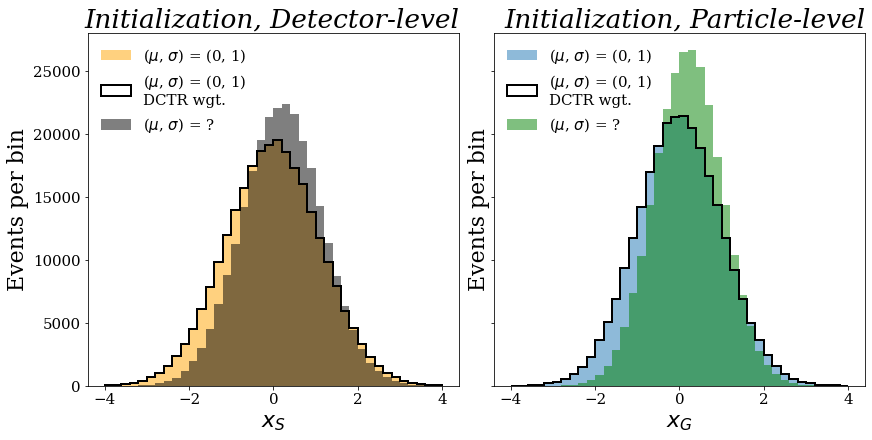

<Figure size 864x360 with 0 Axes>

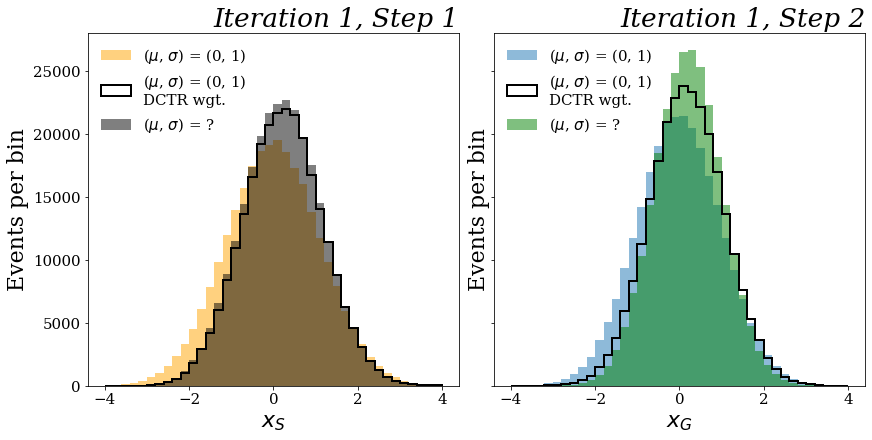

<Figure size 864x360 with 0 Axes>

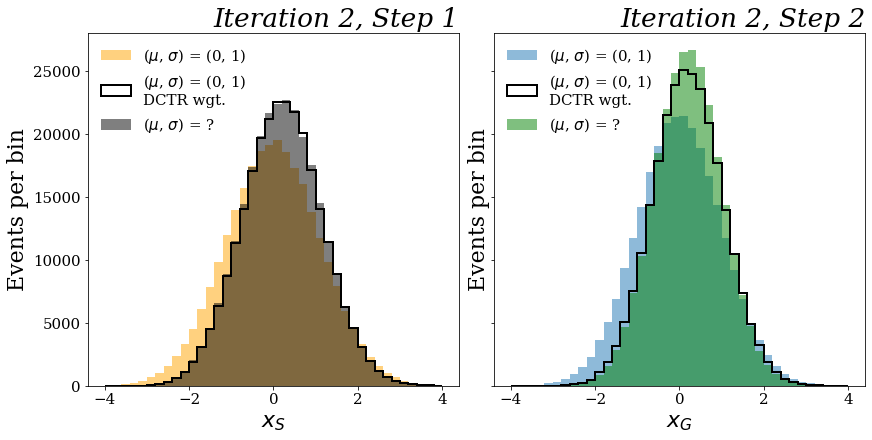

<Figure size 864x360 with 0 Axes>

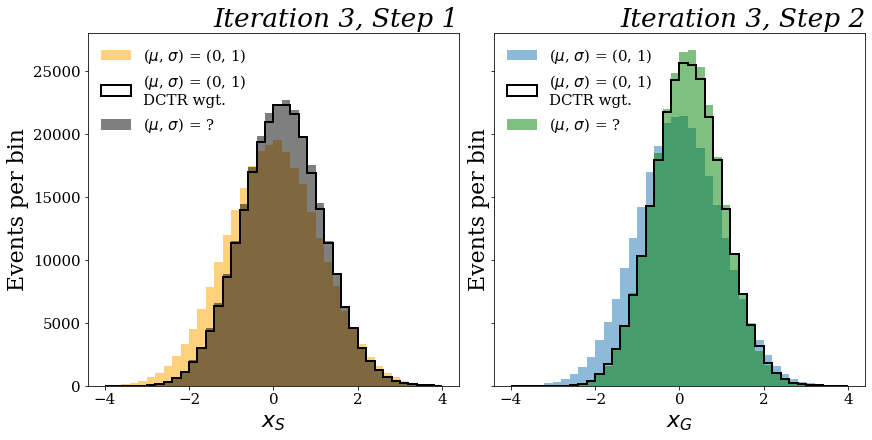

<Figure size 864x360 with 0 Axes>

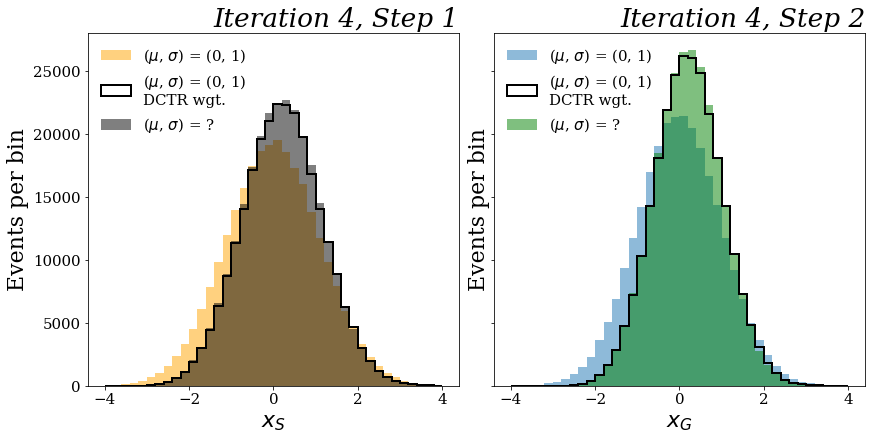

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.14204443, 1.11838114, 0.88499826, ..., 1.02923501,
         1.25106215, 1.0337925 ],
        [1.17897582, 1.07567191, 0.97222668, ..., 1.00615823,
         0.91329205, 1.00989246]],

       [[1.19022531, 1.06903113, 0.96808273, ..., 1.05918941,
         1.01982255, 1.06362043],
        [1.25754237, 1.02826397, 0.98535612, ..., 1.01537895,
         0.90338614, 1.02075386]],

       [[1.24801659, 1.01958883, 0.98161843, ..., 1.02902711,
         0.95707589, 1.03290054],
        [1.29453015, 1.02040833, 0.99357176, ..., 1.0377686 ,
         0.90745636, 1.04097021]],

       [[1.28870048, 1.0125188 , 0.99703373, ..., 1.05238897,
         0.94324139, 1.05477187],
        [1.31960514, 1.02168789, 0.99838694, ..., 1.06922781,
         0.91383319, 1.07699168]]])

In [53]:
weights.shape

(4, 2, 300000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([-6.01564927,  2.48894381,  1.74143277, ...,  4.53375371,
       -5.95613572,  7.11494532])

In [57]:
x_data_and_MCback.shape

(720442,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(720442,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(720442,)

In [62]:
w_data

array([9.0714455e-01, 9.0919858e-01, 9.2869270e-01, ..., 8.5791200e-03,
       1.3828030e-10, 1.3188220e-04], dtype=float32)

In [63]:
w_data.shape

(330221,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([-0.29597648,  0.73729506,  0.46147016, ...,  4.53375371,
       -5.95613572,  7.11494532])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(330221,)

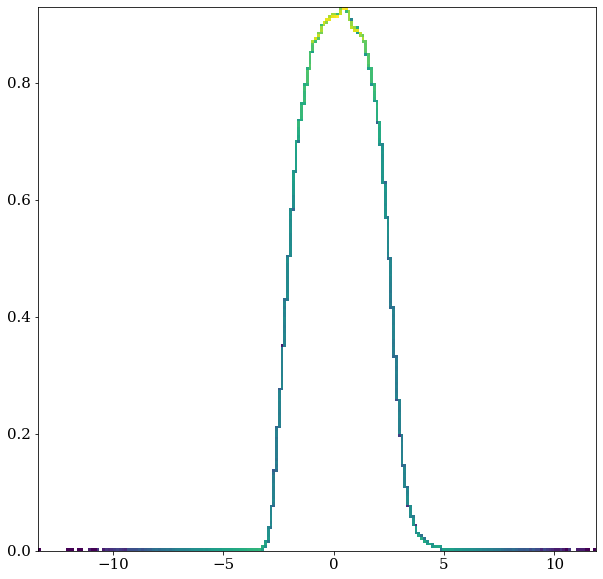

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

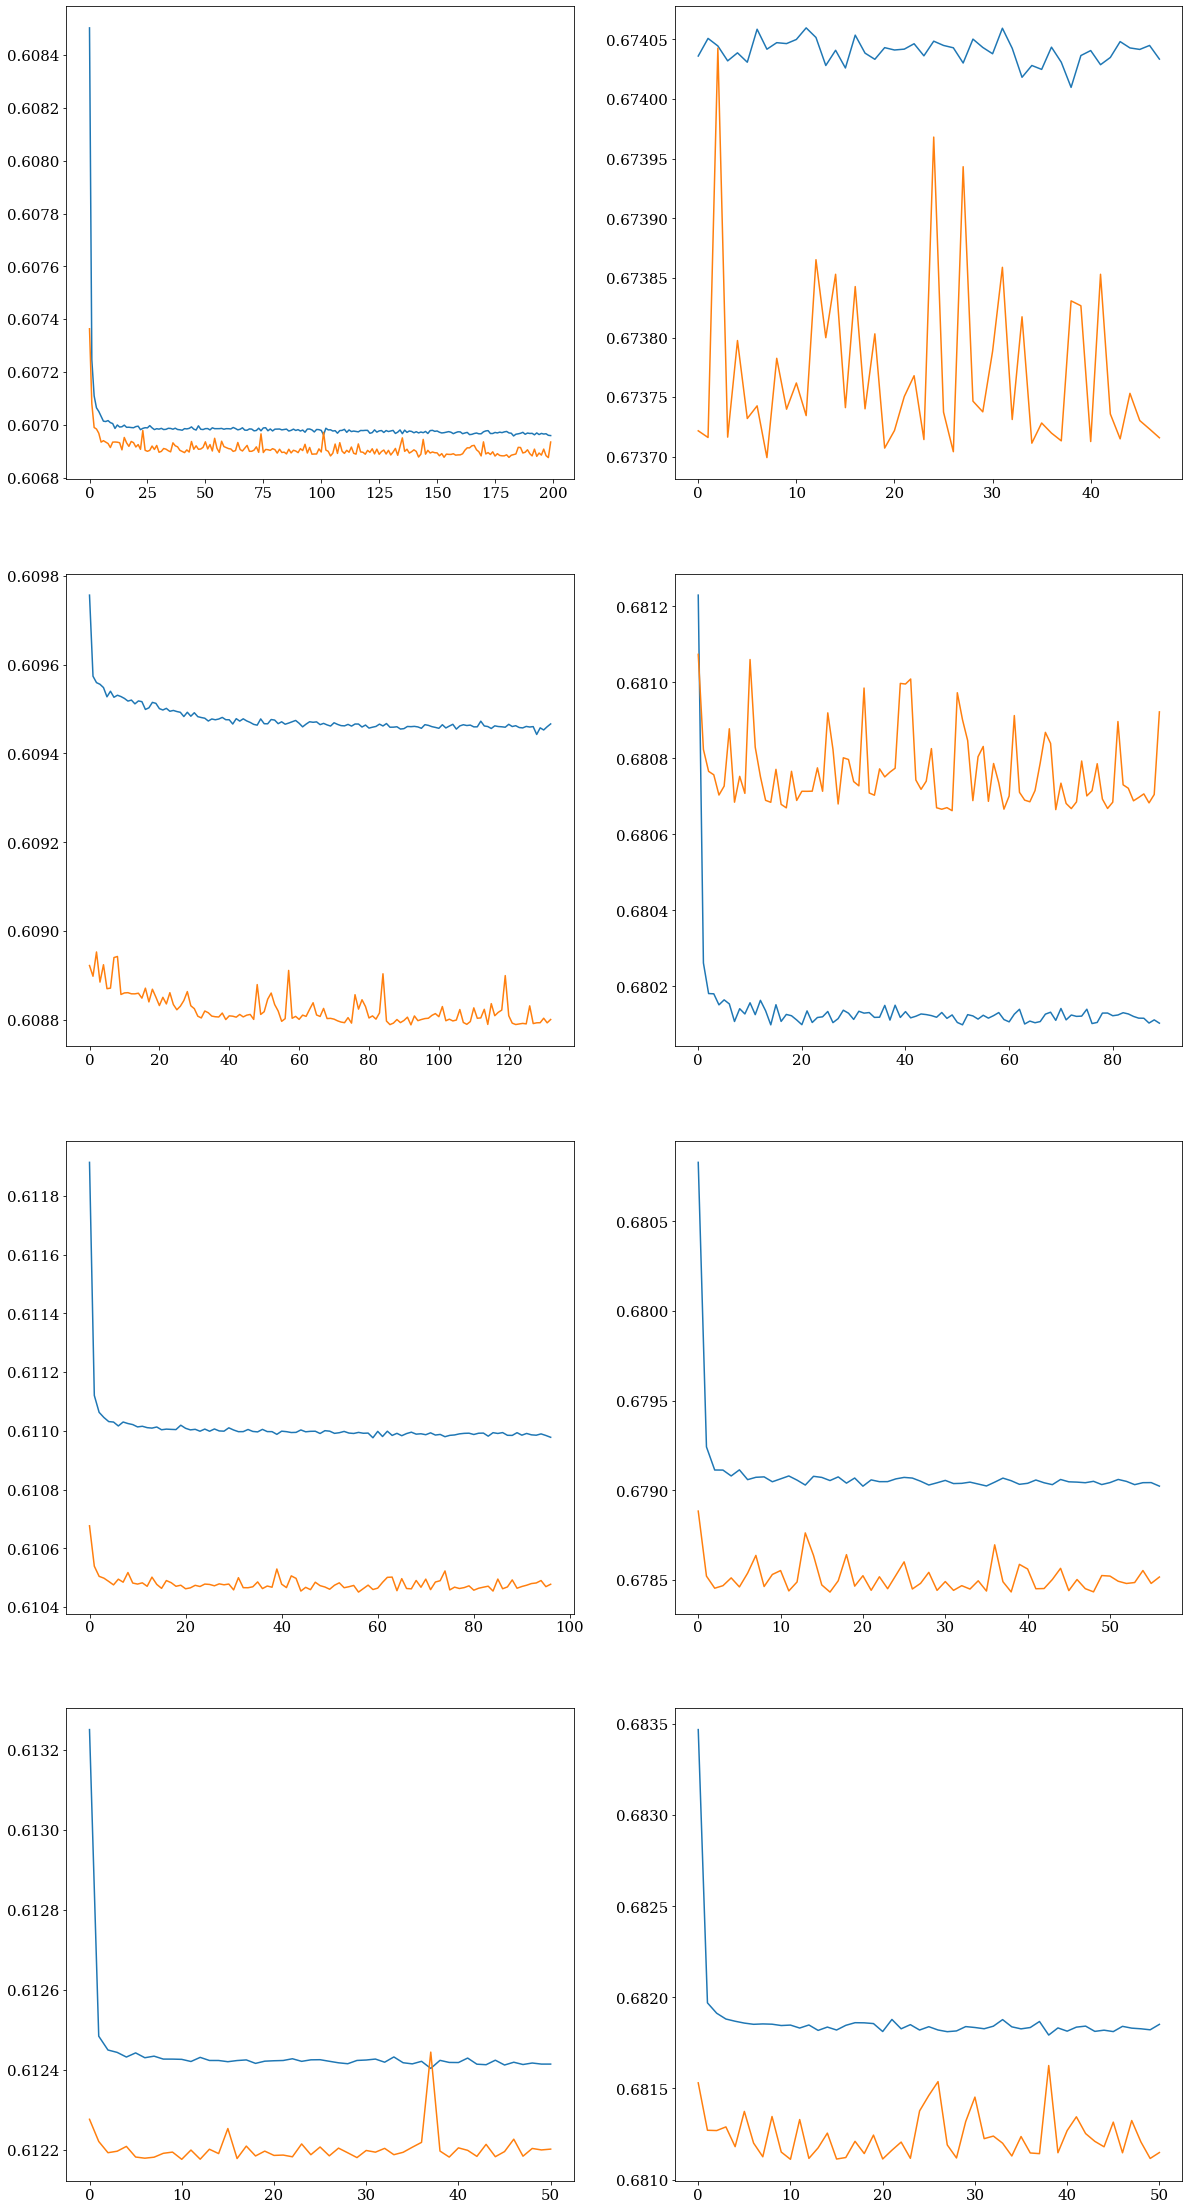

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()

## distributions of weights

### Weights on full simulation to match data (step1)

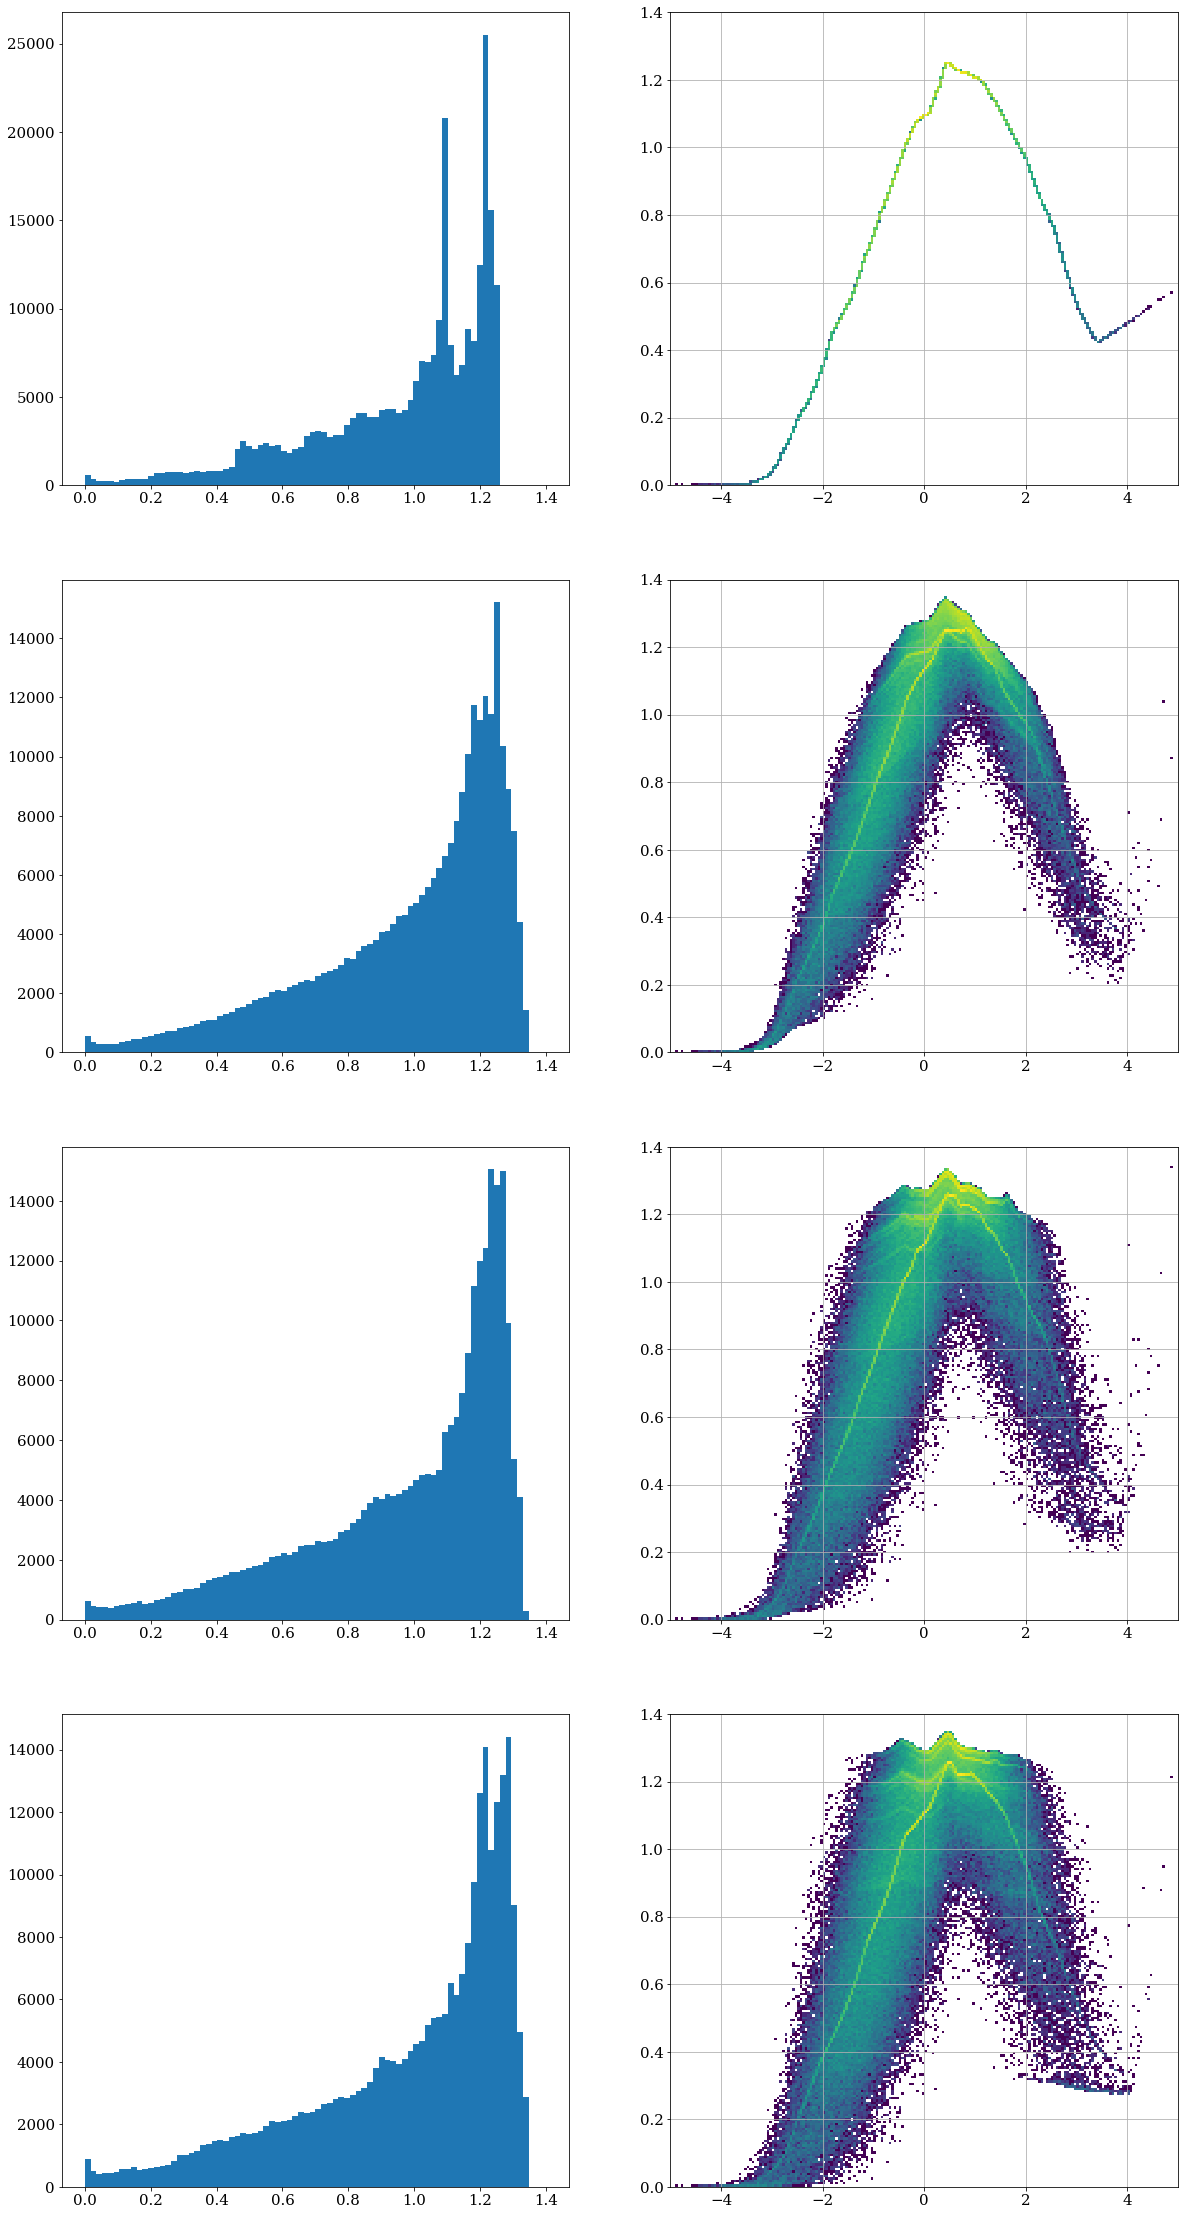

In [68]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,theta0_S!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

### Weights on gen (step2)

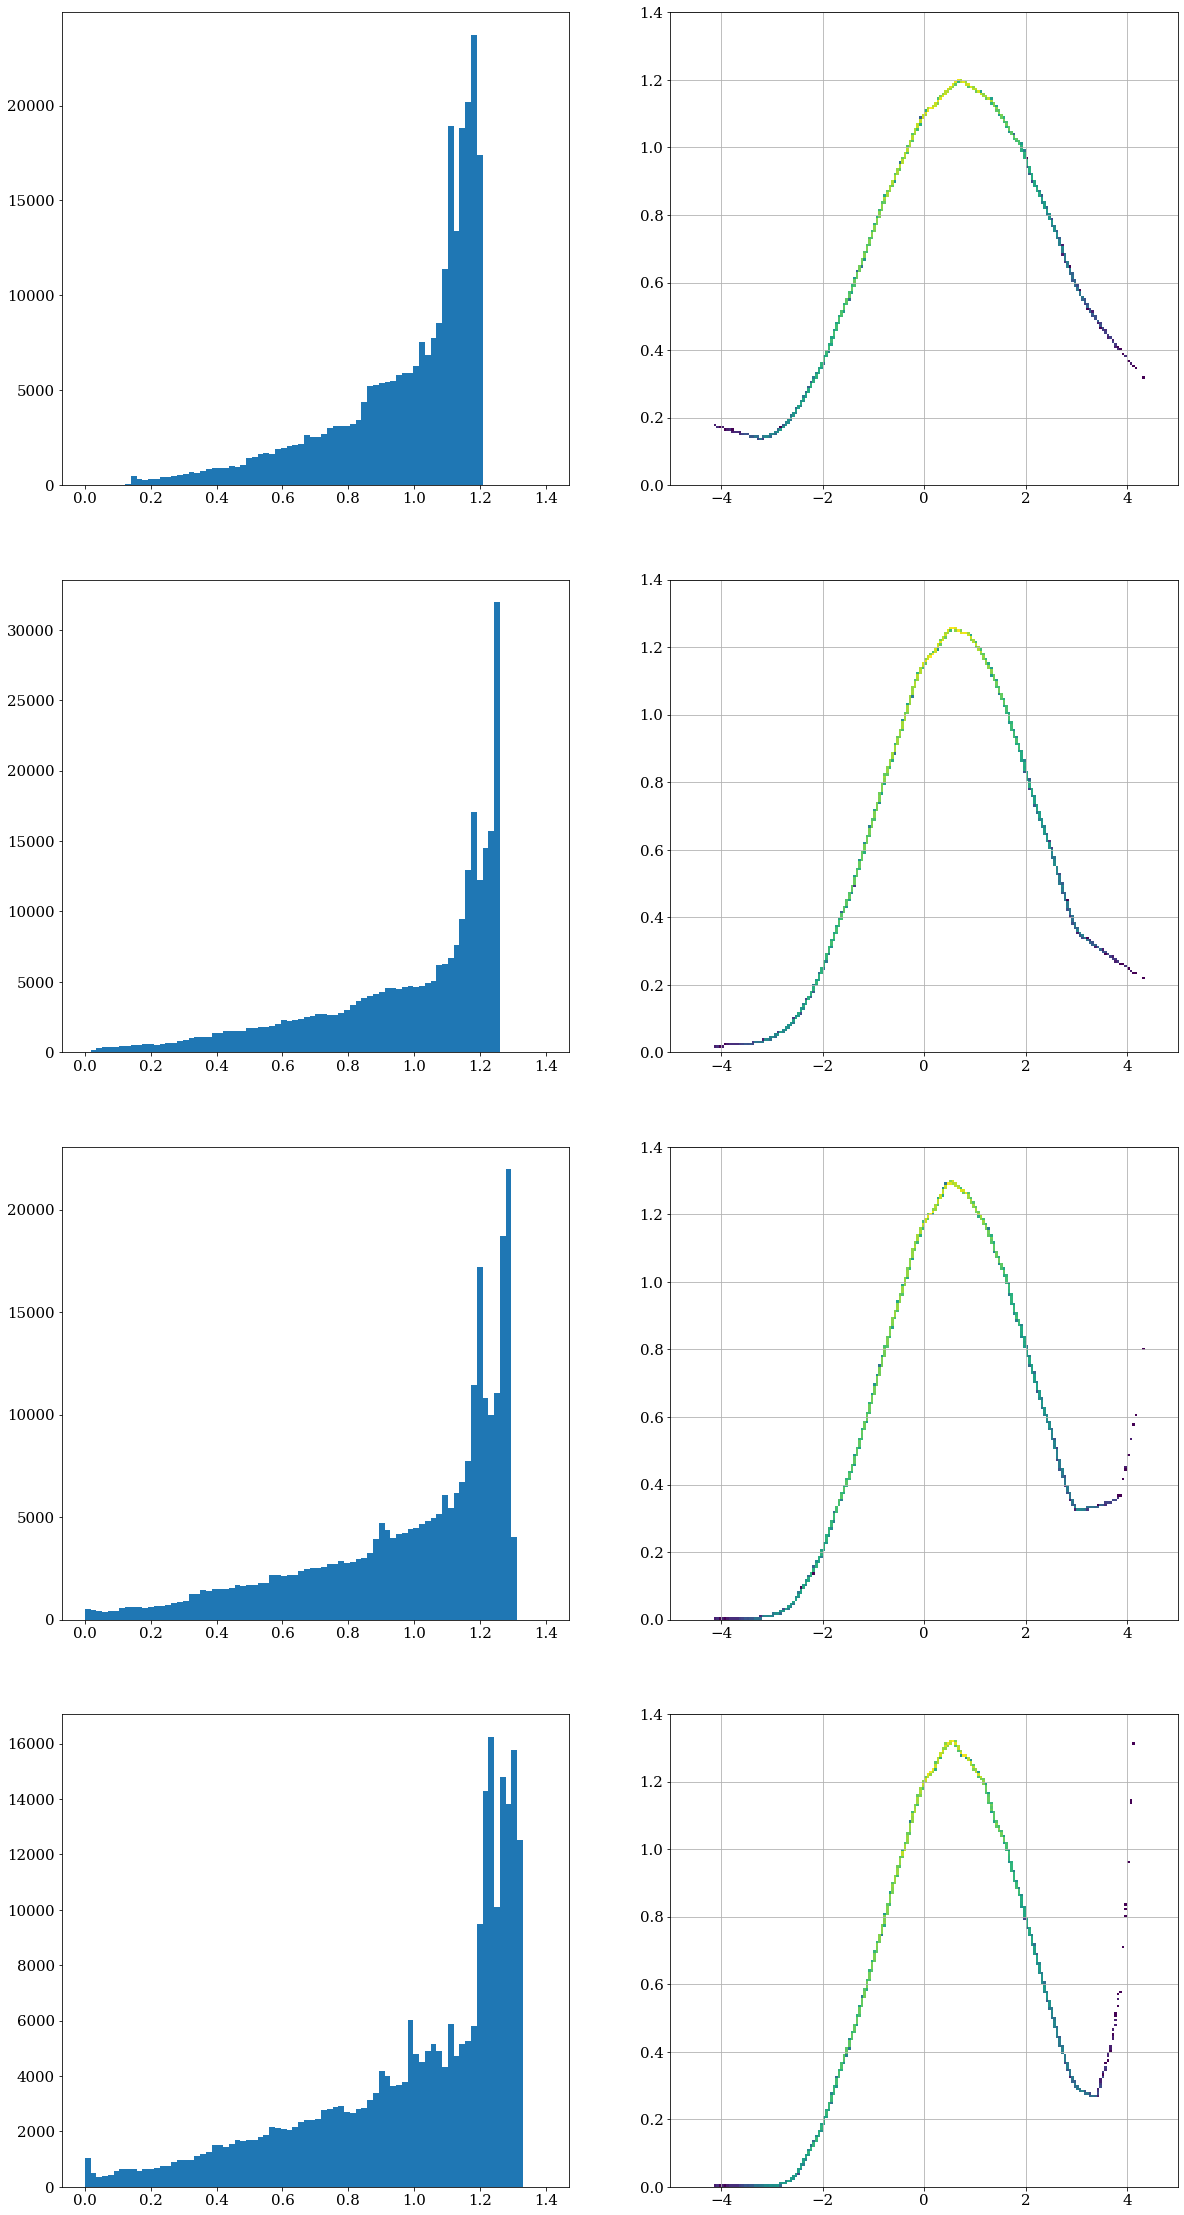

In [69]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,1,theta0_G!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on fullsim (step1) between consecutive iterations

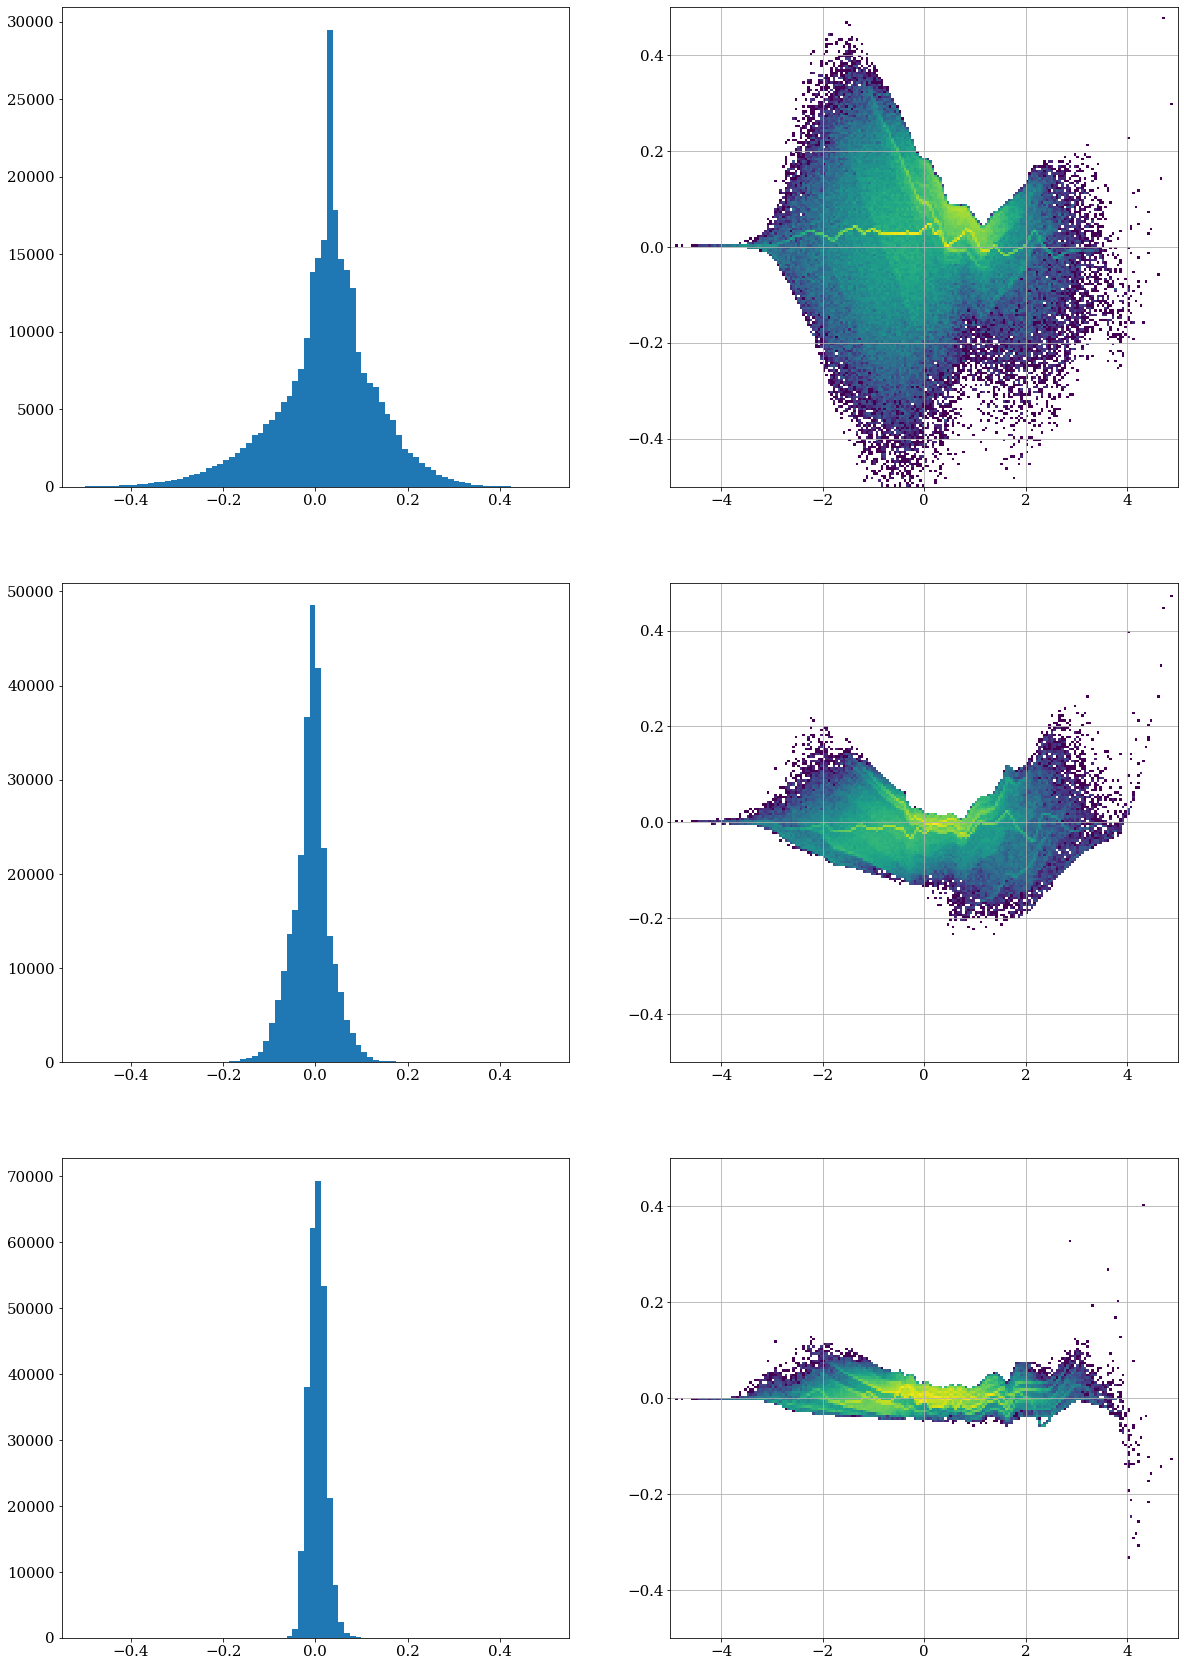

In [70]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], bins=80,
                 range=[-0.5,0.5])
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.5,0.5]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on gen (step2) between consecutive iterations

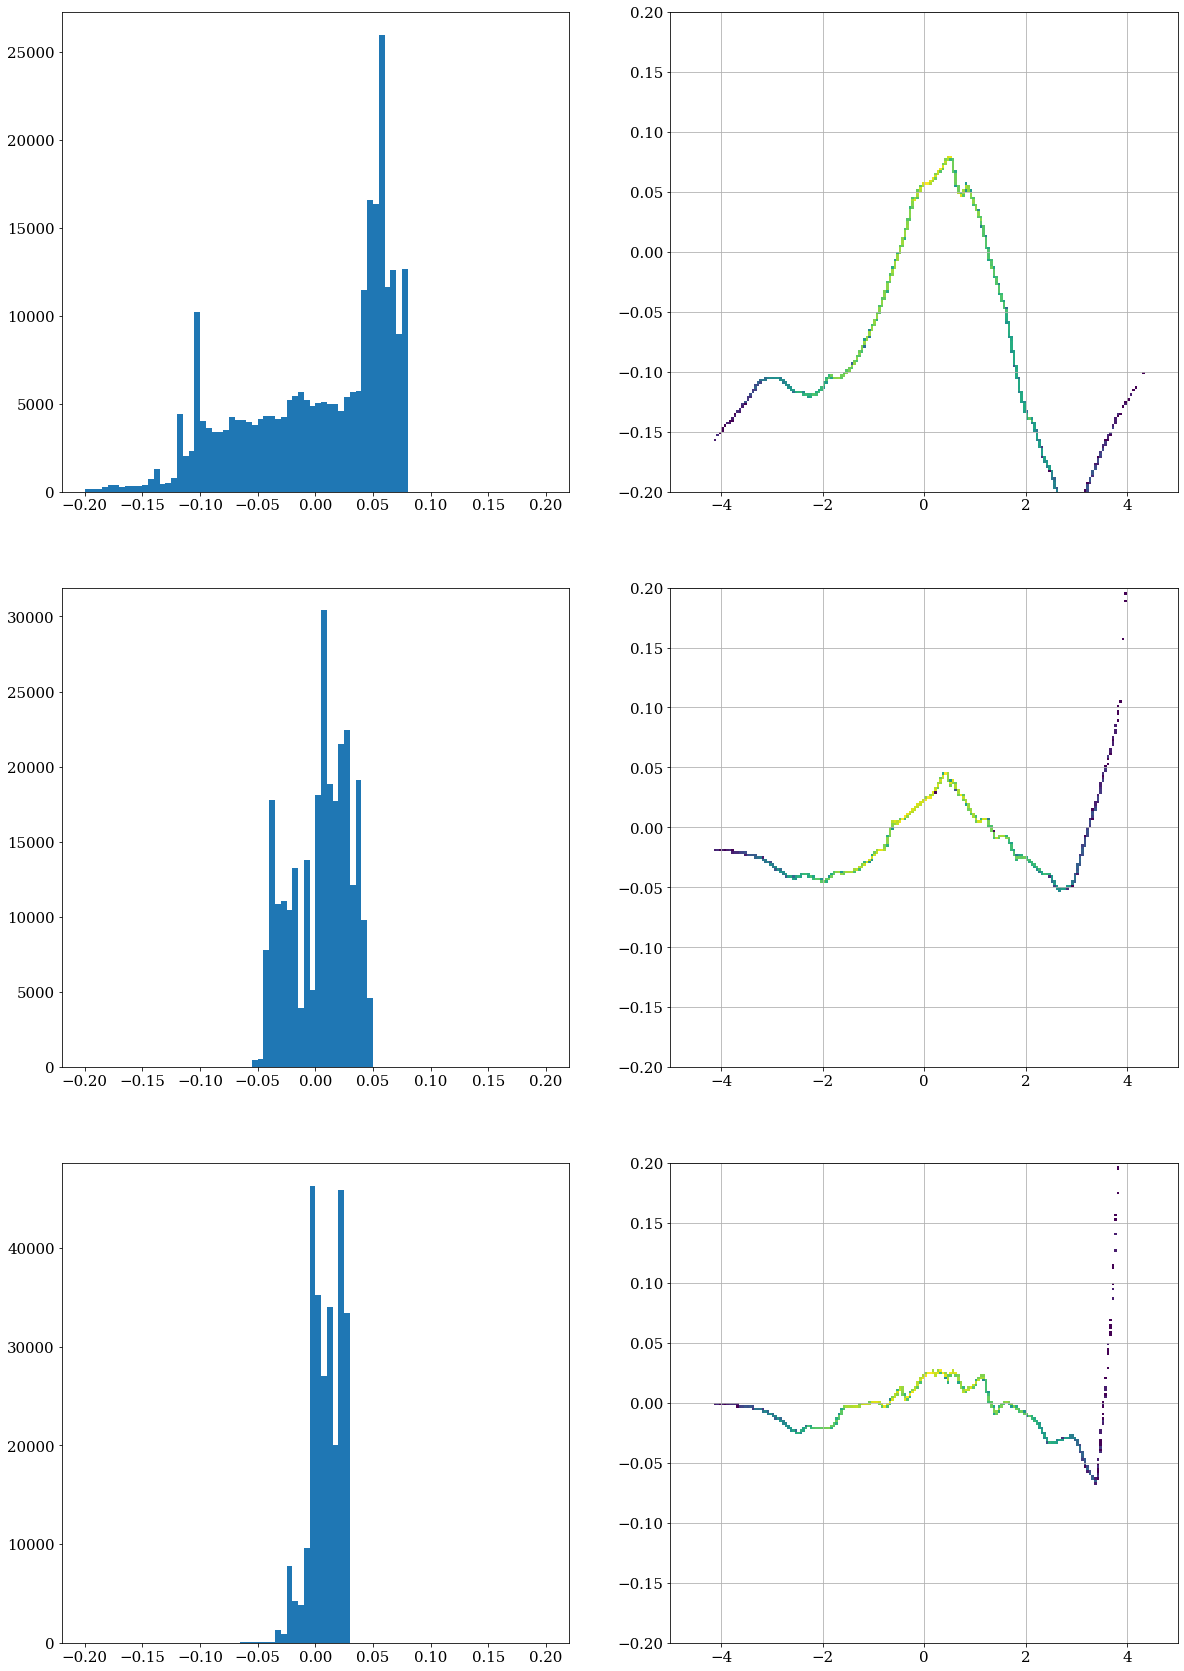

In [71]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], bins=80,
                 range=[-0.2,0.2])
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.2,0.2]))
    ax[i][1].grid()
    
plt.show()

In [72]:
nn_output

array([[[0.53315628, 0.52794141, 0.46949553, ..., 0.50720346,
         0.55576527, 0.50830775],
        [0.54106879, 0.51822829, 0.49295887, ..., 0.50450444,
         0.47734064, 0.50450444]],

       [[0.50237411, 0.4984518 , 0.49893215, ..., 0.5128383 ,
         0.52755409, 0.51295578],
        [0.5161227 , 0.4887335 , 0.50335348, ..., 0.50178641,
         0.49727362, 0.50178641]],

       [[0.49809906, 0.49788189, 0.49904987, ..., 0.50333792,
         0.51442915, 0.50295734],
        [0.50724661, 0.49808276, 0.50207579, ..., 0.50323391,
         0.50112385, 0.50323391]],

       [[0.49887162, 0.49805957, 0.50086957, ..., 0.50349742,
         0.50966799, 0.5032928 ],
        [0.50479603, 0.50031328, 0.50120866, ..., 0.49702305,
         0.50175065, 0.49702305]]])

## Output of NN for step1: distinguish data from fullsim

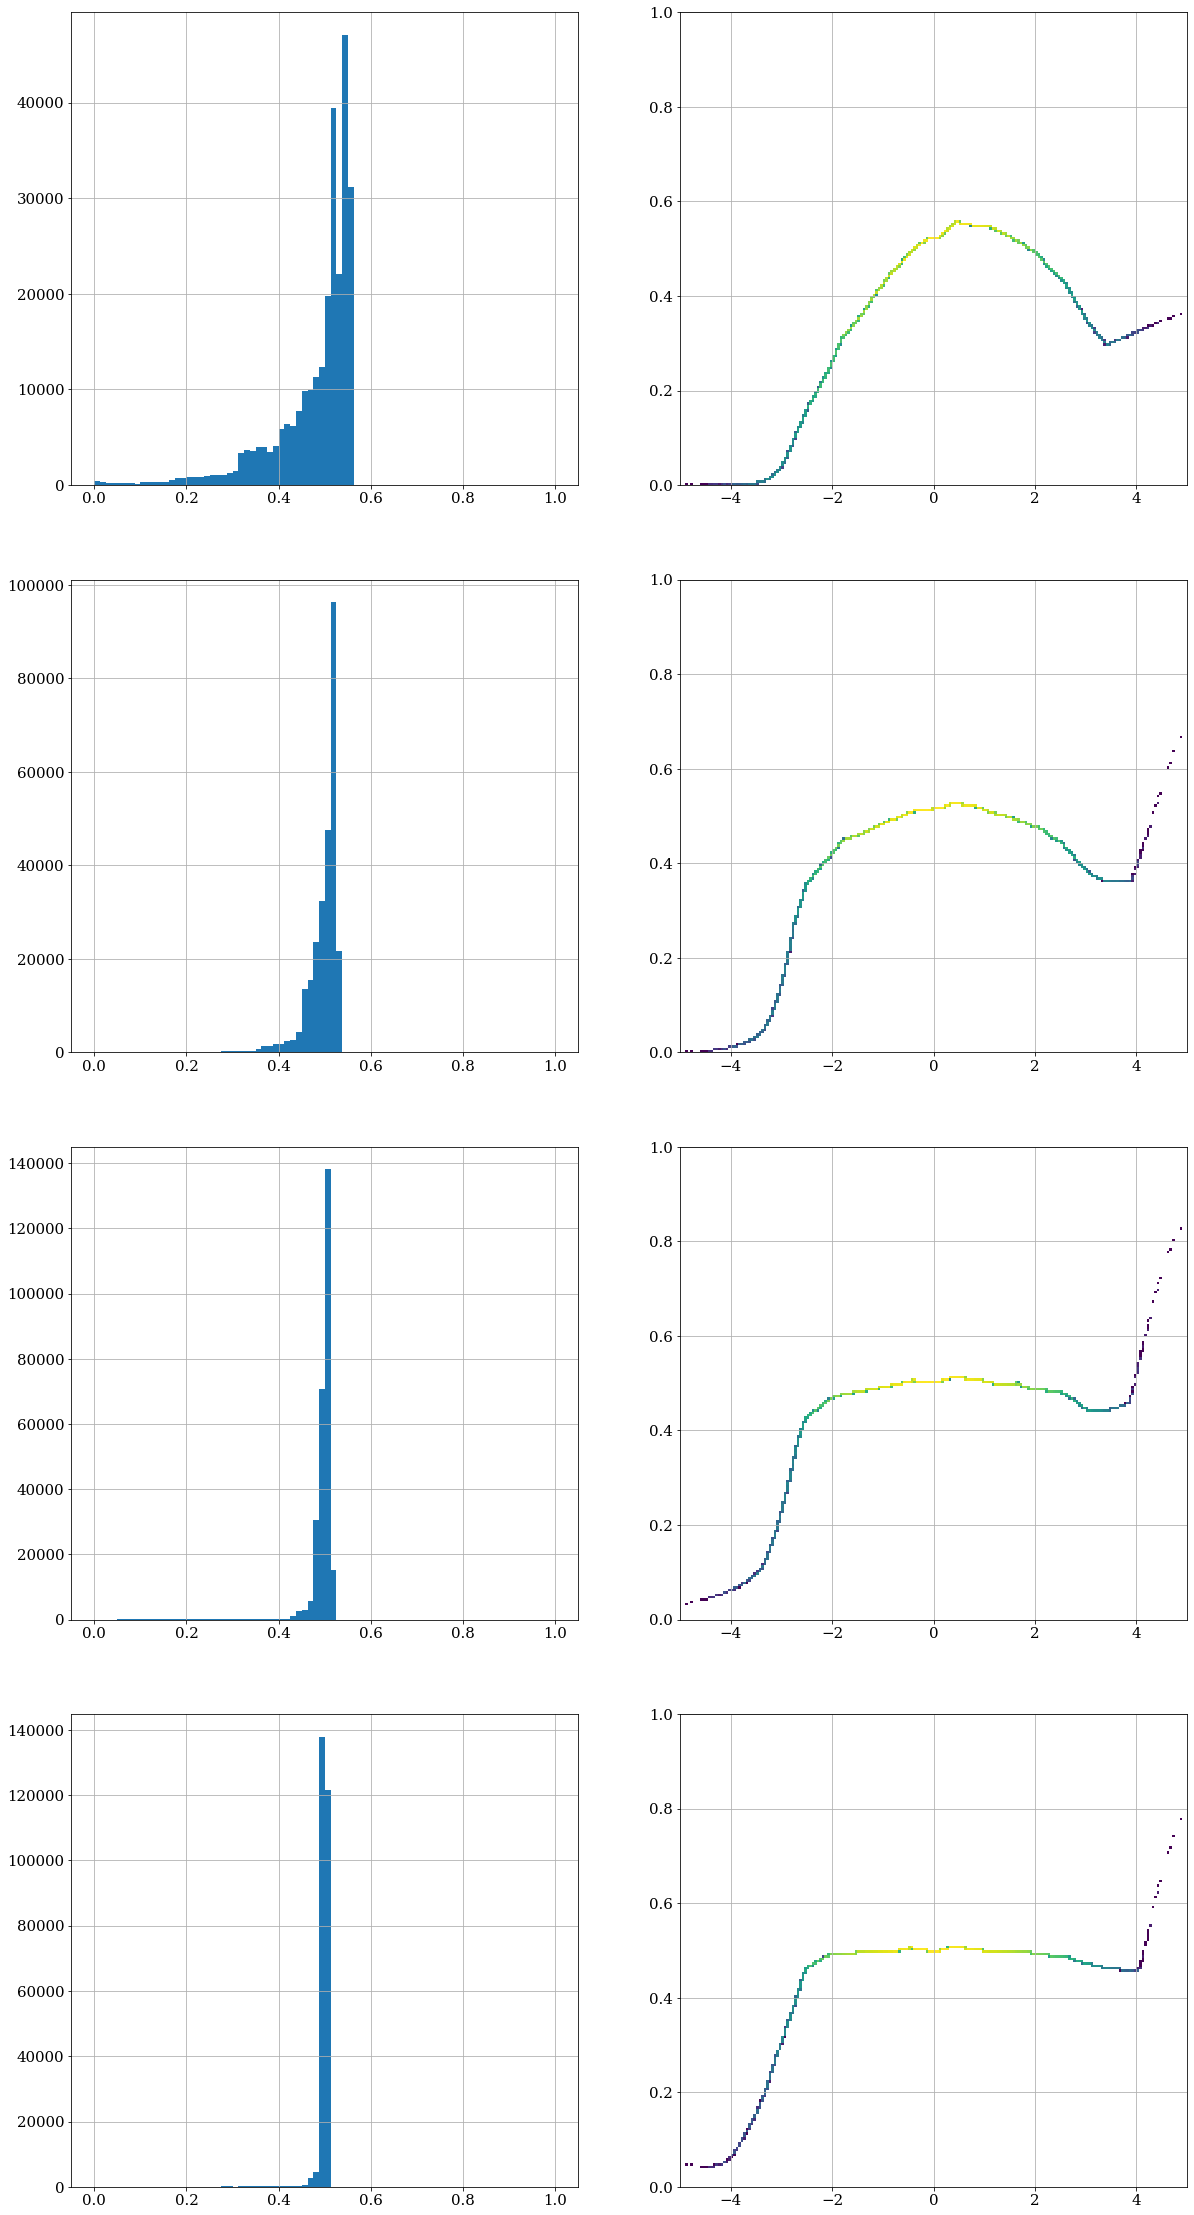

In [73]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,0,theta0_S!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## NN output of step2 : distinguish gen

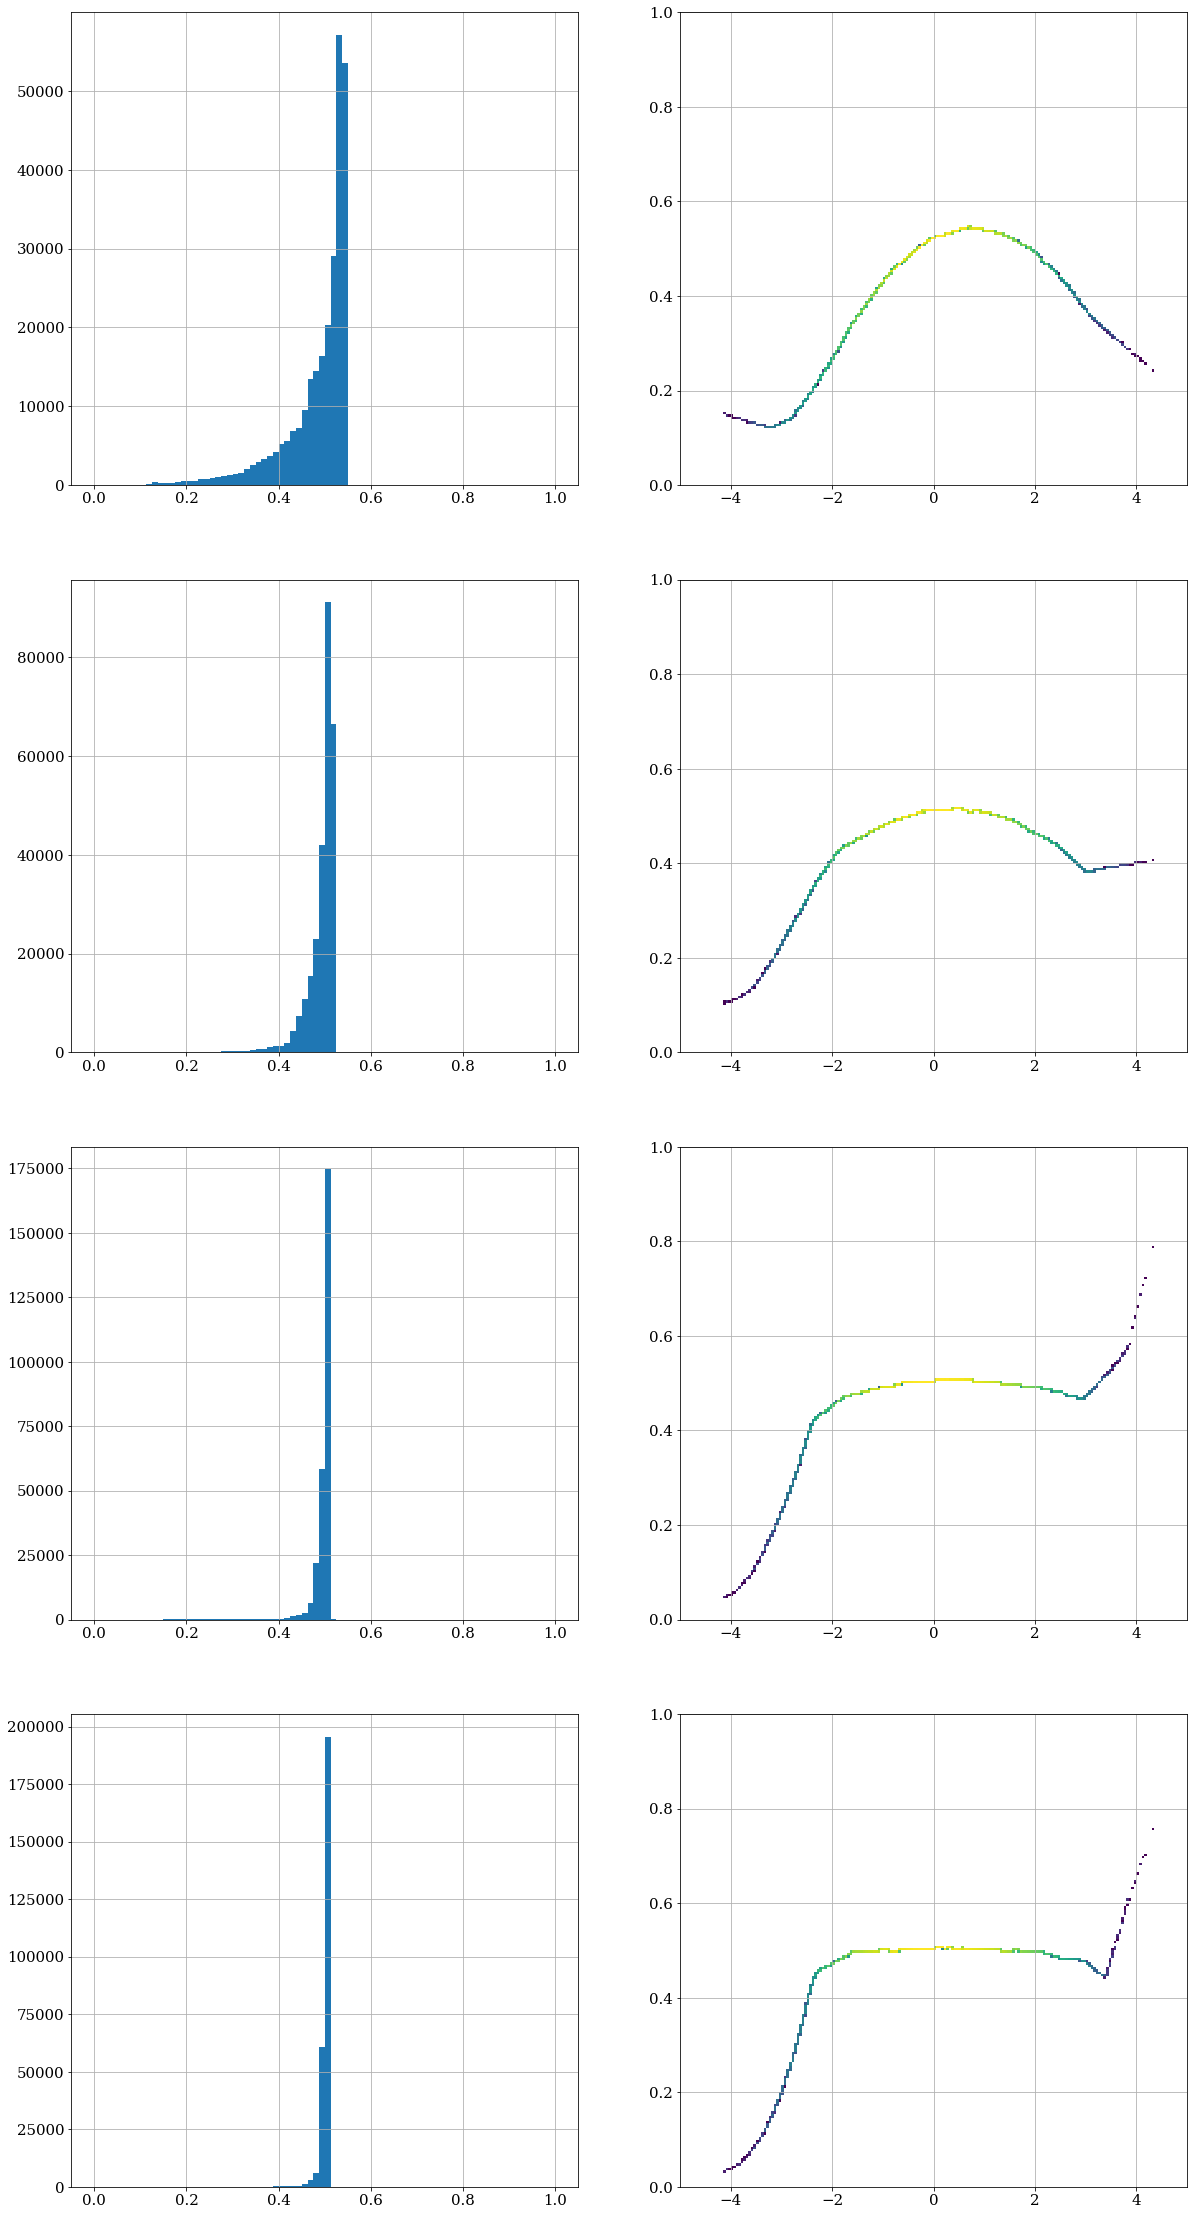

In [74]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,1,theta0_G!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()